# Detect rough long-term layers
Precursor script to the contour stuff. I took contours of a heavily blurred DTS plot in order to get a general idea of the thermocline locations over time. I tried a bunch of different methods (edge detection, etc.) but none worked quite as well as a simple contour.

In [45]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import scipy
from skimage import feature
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
import cv2

# matplotlib.use('TkAgg')
# %matplotlib qt
%matplotlib inline

In [46]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [47]:
# Put temperatur data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [48]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = times[0] #datetime.datetime(2023,8,9)
end_time = times[-1] #datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]
# filtered_arr = cv2.medianBlur(cv2.convertScaleAbs(plot_arr), 101)
# filtered_arr = scipy.ndimage.median_filter(plot_arr, size=101)

In [49]:
with open('filtered_arr.pickle', 'rb') as handle:
    filtered_arr = pickle.load(handle)

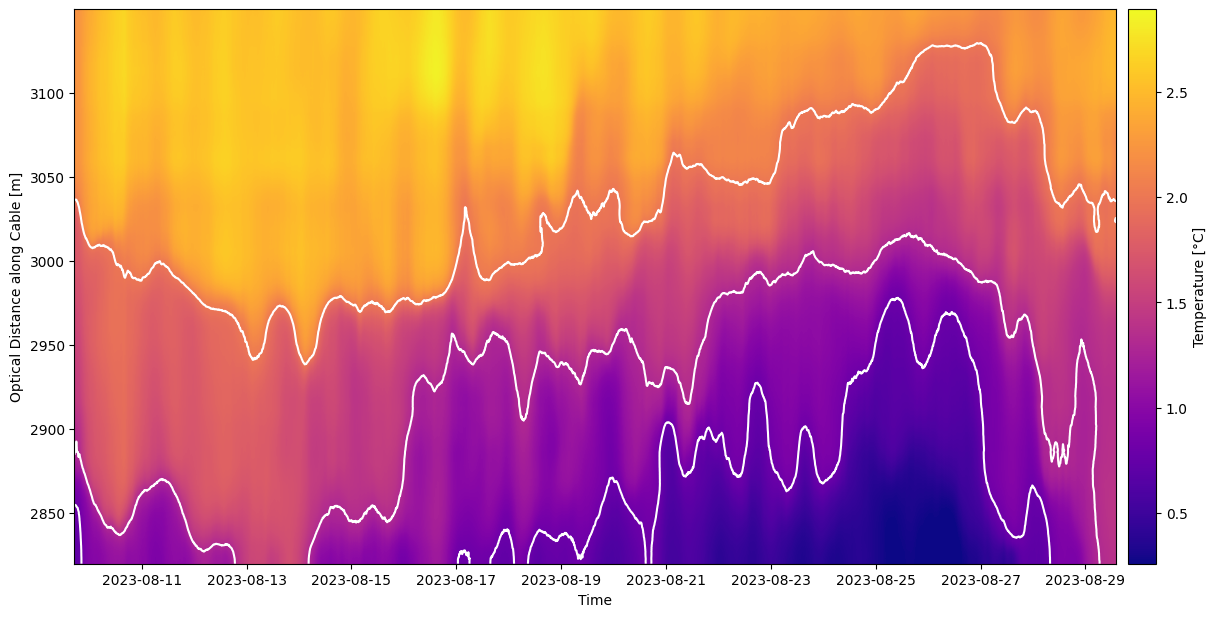

In [50]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# left plot (waterfall-like plot)
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times[0], plot_times[-1],
                   plot_dists[0], plot_dists[-1]],
            cmap='plasma',
            vmin=np.percentile(plot_arr[~np.isnan(plot_arr)],1),
            vmax=np.percentile(plot_arr[~np.isnan(plot_arr)],99),
            # interpolation='none',
            # vmin=3.2,
            # vmax=2.8
            )
X, Y = np.meshgrid(plot_times, plot_dists)
isotherms = ax.contour(X, Y, filtered_arr.T, [0.8, 1.3, 2], colors='white')

# # Remove small circles in contour plot
# for level in isotherms.collections:
#     for kp,path in reversed(list(enumerate(level.get_paths()))):
#         # go in reversed order due to deletions!

#         # include test for "smallness" of your choice here:
#         # I'm using a simple estimation for the diameter based on the
#         #    x and y diameter...
#         verts = path.vertices # (N,2)-shape array of contour line coordinates
#         diameter = np.max(verts.max(axis=1) - verts.min(axis=1))

#         if diameter<16600: # threshold to be refined for your actual dimensions!
#             del(level.get_paths()[kp])  # no remove() for Path objects:(

# this might be necessary on interactive sessions: redraw figure
plt.gcf().canvas.draw()

ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature [°C]')
plt.show()

# Contour refinement using a median filter

/var/folders/zd/7h901qjs6sb24r_mgjqbqp5r0000gp/T/ipykernel_5567/3176069523.py:4: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  contours = isotherms.collections


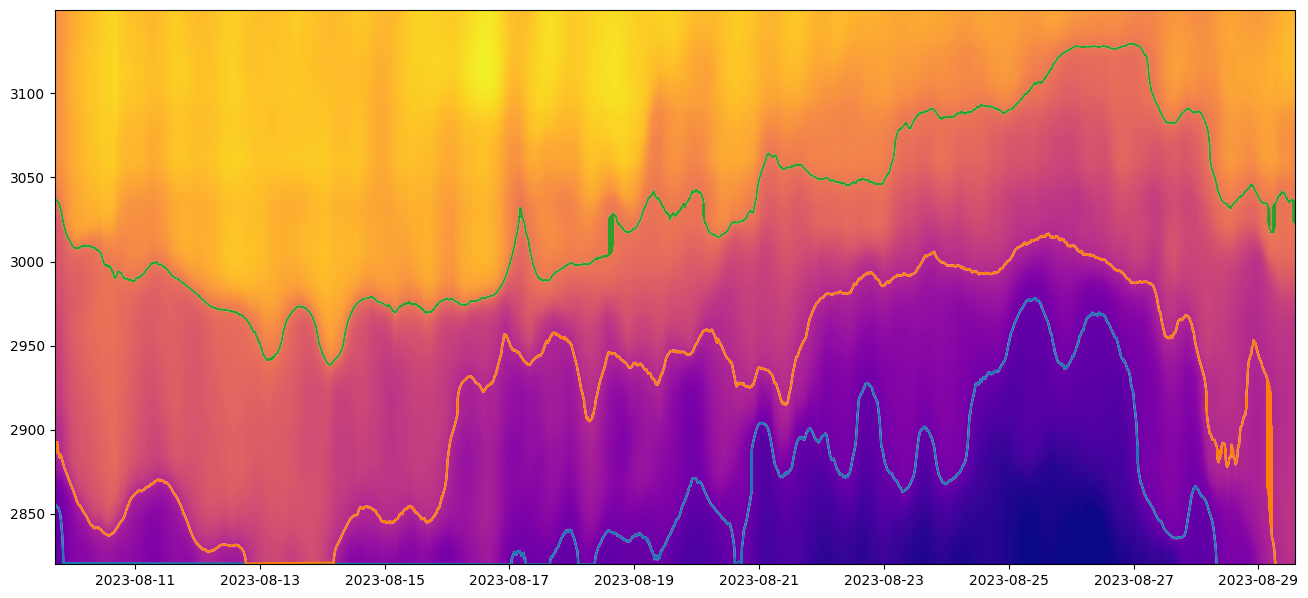

In [51]:
X, Y = np.meshgrid(plot_times, plot_dists)

fig2, ax2 = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
contours = isotherms.collections
line_coordinates = []
for contour in contours:
    for path in contour.get_paths():
        line_coordinates.append(path.vertices)

median_coordinates = [0, 0, 0]
for i in range(len(line_coordinates)):
    df = pd.DataFrame(line_coordinates[i], columns=['x', 'y'])
    median_df = df.groupby('x')['y'].min().reset_index()
    median_coordinates[i] = list(median_df.itertuples(index=False, name=None))

xc1, yc1 = zip(*median_coordinates[0])
xc2, yc2 = zip(*median_coordinates[1])
xc3, yc3 = zip(*median_coordinates[2])

im1 = ax2.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times[0], plot_times[-1],
                   plot_dists[0], plot_dists[-1]],
            cmap='plasma',
            vmin=np.percentile(plot_arr[~np.isnan(plot_arr)],1),
            vmax=np.percentile(plot_arr[~np.isnan(plot_arr)],99),
            # interpolation='none',
            # vmin=3.2,
            # vmax=2.8
            )
ax2.contour(X, Y, filtered_arr.T, [0.8, 1.3, 2], colors='white')
plt.plot(xc1, yc1, '-')
plt.plot(xc2, yc2, '-')
plt.plot(xc3, yc3, '-')
plt.show()

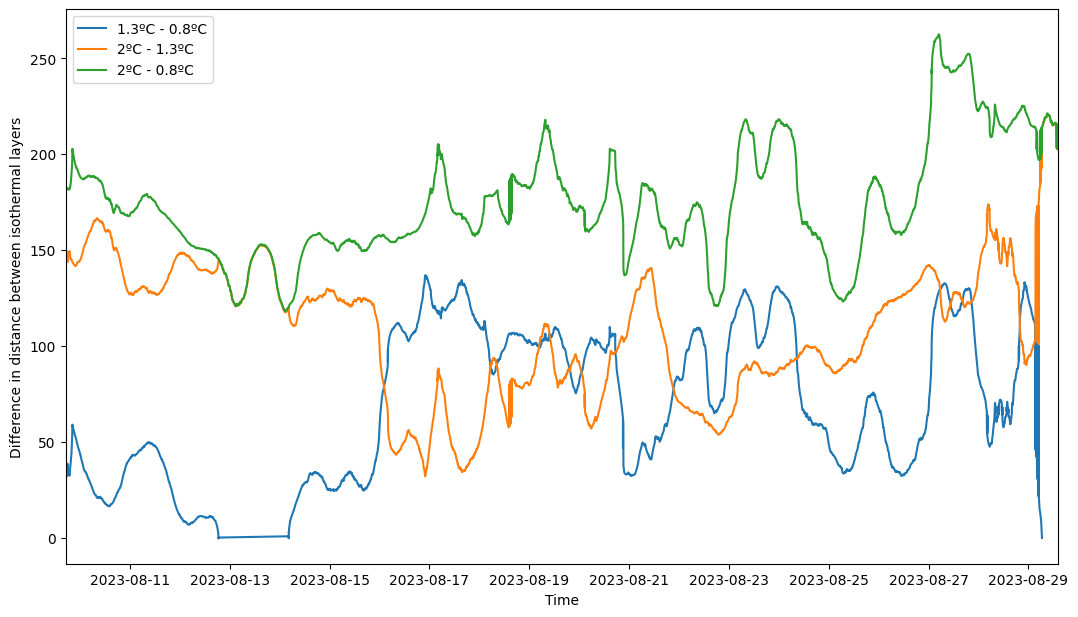

In [52]:
fig3, ax3 = plt.subplots(figsize=(2*6.4,1.5*4.8))
# [0.8, 1.3, 2]
ax3.plot(xc2, yc2 - np.interp(xc2, xc1, yc1)) # Depth difference between 1.3ºC and 0.8ºC layers
ax3.plot(xc3, yc3 - np.interp(xc3, xc2, yc2)) # Depth difference between 2ºC and 1.3ºC layers
ax3.plot(xc3, yc3 - np.interp(xc3, xc1, yc1)) # Depth difference between 2ºC and 0.8ºC layers
ax3.legend(["1.3ºC - 0.8ºC", "2ºC - 1.3ºC", "2ºC - 0.8ºC"])
plt.xlabel("Time")
plt.xlim(plot_times[0], plot_times[-1])
plt.ylabel("Difference in distance between isothermal layers")
plt.show()

## Integrated temperature over distance vs. time

In [62]:
int(plot_times[1].timestamp())

1691601272

In [112]:
(plot_times[1]- plot_times[0]).total_seconds()

300.106

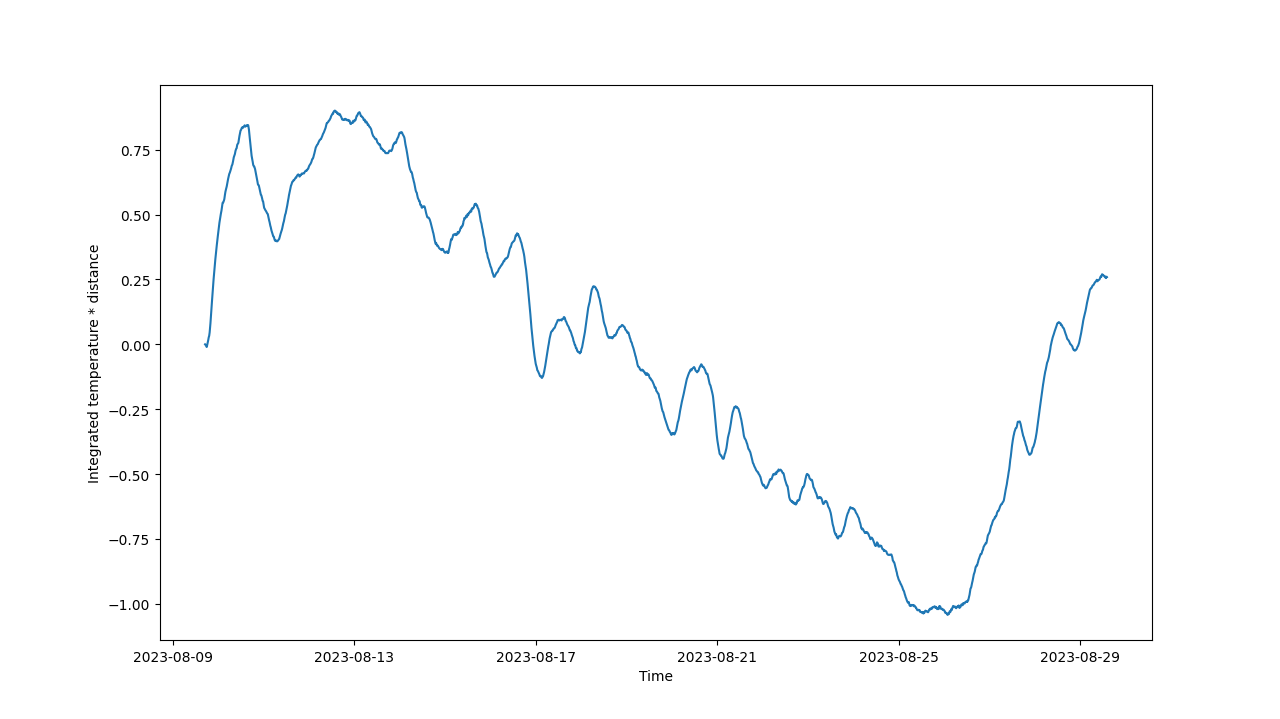

In [126]:
%matplotlib widget
int_temp = filtered_arr.sum(axis=1)
int_plot_times = np.zeros(len(plot_times))
for i in range(len(plot_times)): int_plot_times[i] = int(plot_times[i].timestamp())

fig3, ax3 = plt.subplots(figsize=(2*6.4,1.5*4.8))
vflux = np.gradient(int_temp, (plot_times[1]- plot_times[0]).total_seconds())
filter = scipy.signal.butter(1, 1/(10000), 'lp', fs=5, output='sos', analog=False)
# plt.plot(plot_times, int_temp/len(int_temp))
# plt.plot(plot_times, 9E5 * vflux/273)
plt.plot(plot_times, 9E5/273 * scipy.signal.sosfilt(filter, vflux))
plt.ylabel('Integrated temperature * distance')
plt.xlabel('Time')
plt.show()

# Differentiating wrt dist to detect edges

# Canny edge deetection

In [30]:
edges1 = feature.canny(filtered_arr, sigma=1)
edgespoints = []
xedge = []
yedge = []
for i in tqdm(range(len(edges1[:, 1]))):
    for j in range(len(edges1[1, :])):
        if(edges1[i, j] == True):
              edgespoints.append([plot_times[i], plot_dists[j]])
              xedge.append(i)
              yedge.append(j)

100%|██████████| 5714/5714 [00:06<00:00, 916.17it/s]


In [31]:
# with open("boundary_estimate", "rb") as fp:   # Unpickling
#     boundary_estimate = pickle.load(fp)
# xbnd, ybnd = zip(*boundary_estimate)
# def pop_indices(lst, indices):
#     # Sort the indices in reverse order to avoid index shifting issues
#     for index in sorted(indices, reverse=True):
#         if 0 <= index < len(lst):
#             lst.pop(index)
#     return lst


# delind = []
# tempx = xedge
# tempy = yedge
# for i in range(len(xedge)):
#     # print(i)
#     closestpt = min(boundary_estimate, key=lambda point: math.hypot(yedge[i]-point[1], xedge[i]-point[0]))
#     if(closestpt[1] > yedge[i]):
#         delind.append(i)

# xedge = pop_indices(xedge, delind)
# yedge = pop_indices(yedge, delind)

# # Fit a curve to the edge data point
# spline = UnivariateSpline(xedge, yedge, s=1)
# x_fit = np.linspace(min(xedge), max(xedge), 1000)
# y_fit = spline(x_fit)

# plt.xlim((datetime.datetime(2023, 8, 15), datetime.datetime(2023, 8, 17)))
# plt.ylim((2930, 2990))

# plt.plot(x_fit, y_fit, '-')

# x, y = zip(*edgespoints)
# plt.scatter(xedge, yedge, c='Black', s=0.1)
# plt.plot(xbnd, ybnd, '-')
# im2 = plt.imshow(edges1.T, cmap='gray_r', alpha = .4,
#                  extent=[plot_times[0], plot_times[-1],
#                    plot_dists[0], plot_dists[-1]],
#                    aspect='auto')

# cbar = fig.colorbar(im1, pad=0.01)
# cbar.set_label('Temperature [°C]')

In [32]:
# bound_points = []
with open("upper_first_set", "rb") as fp:   #Pickling
  bound_points = pickle.load(fp)

def onclick(event):
    # Check if the mouse event is a left button click
    if event.button == 1 and event.key == 'shift':
        # Append the x and y coordinates of the click to the list
        bound_points.append((event.xdata, event.ydata))
        print(f"Point clicked: ({event.xdata}, {event.ydata})")
        
        # Plot the clicked point
        plt.plot(event.xdata, event.ydata, 'ro')
        plt.draw()

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# left plot (waterfall-like plot)
im1 = plt.imshow(plot_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times[0], plot_times[-1],
                   plot_dists[0], plot_dists[-1]],
            cmap='plasma',
            vmin=np.percentile(plot_arr[~np.isnan(plot_arr)],1),
            vmax=np.percentile(plot_arr[~np.isnan(plot_arr)],99),
            # interpolation='none',
            # vmin=3.2,
            # vmax=2.8
            )
xb, yb = zip(*bound_points)
plt.plot(xb, yb, '-')
cid = fig.canvas.mpl_connect('button_press_event', onclick)
ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')
plt.show()


In [33]:
plt.close()

In [34]:
#  with open("upper_first_set", "wb") as fp:   #Pickling
#     pickle.dump(bound_points, fp)

with open("upper_first_set", "rb") as fp:   #Pickling
  bound_points = pickle.load(fp)


In [35]:
# xb, yb
xinterp = np.linspace(min(xb), max(xb), 1000)
ybinterp = np.interp(xinterp, xb, yb)

bound_points_fft = scipy.fftpack.dct(ybinterp - np.mean(yb))
# xbfft, ybfft = zip(*bound_points_fft)
plt.plot(bound_points_fft, '-')
plt.show()

# Ridge operators edge detection

In [36]:
def original(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image

image = filtered_arr
cmap = plt.cm.gray

plt.rcParams["axes.titlesize"] = "medium"
axes = plt.figure(figsize=(10, 8))
black_ridges = False
sigmas = range(1, 10)
result = meijering(image, black_ridges=black_ridges, sigmas=sigmas)


edgespoints = []
for i in tqdm(range(len(result[:, 1]))):
    for j in range(len(result[1, :])):
        if(result[i, j] > 0.4):
              edgespoints.append([plot_times[i], plot_dists[j]])


plt.scatter(*zip(*edgespoints), c='Black', s=0.1)

# left plot (waterfall-like plot)
im1 = plt.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times[0], plot_times[-1],
                   plot_dists[0], plot_dists[-1]],
            cmap='plasma',
            vmin=np.percentile(plot_arr[~np.isnan(plot_arr)],1),
            vmax=np.percentile(plot_arr[~np.isnan(plot_arr)],99),
            # interpolation='none',
            # vmin=3.2,
            # vmax=2.8
            )

plt.show()


100%|██████████| 5714/5714 [00:01<00:00, 3685.41it/s]


# Active contour model

In [37]:
img = filtered_arr

r = np.linspace(800, 750, 1000)
# c = np.linspace(int(plot_times[0].timestamp()), int(plot_times[-1].timestamp()), 100)
c = np.linspace(0, 200, 1000)
init = np.array([r, c]).T

snake = active_contour(
    img,
    init,
    boundary_condition='fixed',
    alpha=0,
    beta=0,
    w_line=0,
    w_edge=8,
    gamma=0.1,
    max_num_iter=2500
)

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))

im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            cmap='plasma',
            vmin=np.percentile(plot_arr[~np.isnan(plot_arr)],1),
            vmax=np.percentile(plot_arr[~np.isnan(plot_arr)],99),
            )
plt.plot(init[:, 1], init[:, 0], '--r', lw=3)
plt.plot(snake[:, 1], snake[:, 0], '-b', lw=3)

plt.show()

In [205]:
int(plot_times[-1].timestamp())

1693317717